# Identitiy
---

2702234081 - Aldo Oktavianus<br>
Link Video ; https://drive.google.com/drive/folders/1hIAWtv7KjCXRuNgFwYPol72dKU-AeBk-

Link Bacup drive : https://drive.google.com/drive/folders/1T7EcIOUBQbmbqVVzpZkioMOBSsLucdtW

# Task
---

In this number 2 task of Deep Learning Final Exam we are asked to build an archtecture for AutoEncoder which purpose is reconstruct images with noise (Denoising Encoder). Unfortunately we dont have enough data with noise so we need to make sone noised data using Gaussian Noise.

This project real world application is to clean noisy data that we took from a camera. Sometimes camera image result can be noisy and make the data not usable. By developing this model, we able to build a tool to clean noised data from real world data

The data we have are pictures of pistachio of 2 variety : siirt and kirmizi

# Library
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate, MaxPooling2D, UpSampling2D, Cropping2D, Resizing
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import seaborn as sns

import os
import cv2
from skimage.util import random_noise # For adding noise
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage.metrics import structural_similarity as ssim


from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
def set_global_styles():
    # Set the style for seaborn so I can make the to be yellow
    # (i prefer it cause its more "eye friendly" xixixixixi)
    sns.set_style({"axes.facecolor": "lightyellow",
                "figure.facecolor": "lightyellow"})

    # this one is for matplotlib
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['axes.facecolor'] = 'lightyellow'
    plt.rcParams['figure.facecolor'] = 'lightyellow'

set_global_styles()

# A. Exploratory Data Analysis
---

Before we do further process, it will be better if we do some Exploratory Data Analysis for our data to know about the characteristics of the picture itself. This way we would be able to know what kind of data preprocessing we need to do to the data, and we would be able to know if there are any data anomalies in the dataset

## Size and channel of images

In [5]:
def analyze_image_dimensions(dataset_path):
    image_details = {}
    non_rgb_images = []
    unreadable_images = []

    print(f" analysis for directory: {dataset_path}\n")

    for root, _, files in os.walk(dataset_path):
        for file in files:
            
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(root, file)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        mode = img.mode
                        image_details[img_path] = (width, height, mode)
                        if mode != "RGB":
                            non_rgb_images.append(img_path)

                except (IOError, UnidentifiedImageError) as e:
                    print(f"Could not read file {img_path}: {e}")
                    unreadable_images.append(img_path)
    
    return {
        'details': image_details,
        'non_rgb_images': non_rgb_images,
        'unreadable_images': unreadable_images,
    }

dataset_directory = "Dataset/"
analysis = analyze_image_dimensions(dataset_directory)
print("\n\n--- Full Image Report ---")
if analysis['details']:
    for path, (w, h, mode) in analysis['details'].items():
        print(f"File: {os.path.basename(path):<25} | Dimensions: {f'{w}x{h}':<12} | Mode: {mode}")
else:
    print("No valid images were found in the specified directory.")
    print("\n\n--- Non-RGB Image Summary ---")
    non_rgb_list = analysis['non_rgb_images']
    print(f"Found {len(non_rgb_list)} images that are not in standard 'RGB' mode.")
    if non_rgb_list:
        for path in non_rgb_list:
            _, _, mode = analysis['details'][path]
            print(f"  -> {path} (Mode: {mode})")

 analysis for directory: Dataset/



--- Full Image Report ---
File: kirmizi 1000.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1001.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1002.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1003.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1004.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1005.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1006.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1007.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1008.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1009.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1010.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1011.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 1012.jpg          | Dimensions: 600x600      | Mode: RGB
File: kirmizi 

In this code we can see that all of the data is at 600x600 pictures with all picture being RBG meaning that we only have to resize it to 100x100 later on without changing the channels any further


## Brightness of Images

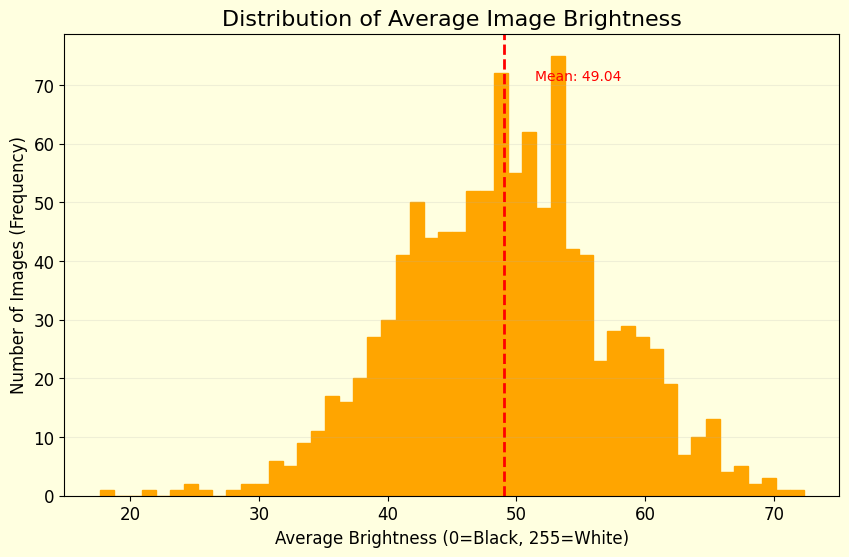

In [6]:
dataset_directory = "Dataset/"

if not os.path.isdir(dataset_directory):
    print(f"Error: The specified directory does not exist: '{dataset_directory}'")
else:
    brightness_values = []
    unreadable_files = []
    for root, _, files in os.walk(dataset_directory):
        for file in files:
            # Check for common image file extensions
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(root, file)
                try:
                    with Image.open(img_path) as img:
                        grayscale_img = img.convert('L') 
                        img_array = np.array(grayscale_img)
                        brightness = np.mean(img_array)
                        brightness_values.append(brightness)
                        
                except (IOError, UnidentifiedImageError) as e:
                    print(f"Could not read file {img_path}: {e}")
                    unreadable_files.append(img_path)

    if brightness_values:
        mean_val = np.mean(brightness_values)
        std_val = np.std(brightness_values)
        min_val = np.min(brightness_values)
        max_val = np.max(brightness_values)
        plt.figure(figsize=(10, 6))
        plt.hist(brightness_values, bins=50, color='orange', edgecolor='orange')
        
        plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
        plt.text(mean_val * 1.05, plt.ylim()[1] * 0.9, f'Mean: {mean_val:.2f}', color='red')

        plt.title('Distribution of Average Image Brightness', fontsize=16)
        plt.xlabel('Average Brightness (0=Black, 255=White)', fontsize=12)
        plt.ylabel('Number of Images (Frequency)', fontsize=12)
        plt.grid(axis='y', alpha=0.2)
        plt.show()

In [7]:
print(f"Overall Mean Brightness: {mean_val:.2f}")
print(f"Standard Deviation: {std_val:.2f}")
print(f"Min Brightness: {min_val:.2f}")
print(f"Max Brightness: {max_val:.2f}")

Overall Mean Brightness: 49.04
Standard Deviation: 7.99
Min Brightness: 17.63
Max Brightness: 72.37


> **Answer for The exam question A. [LO1, LO2, LO4 – 5 poin] Untuk mengenali data, anda perlu melakukan EDA kemudian menjelaskan EDA apa yang anda lakukan dan informasi apa yang anda peroleh dengan EDA tersebut, serta alasan mengapa anda perlu mengetahui informasi tersebut. <br><br>**
The information i got is the size, channel, and the brightness of the data
By knowing this information i would be able to: <br>
> - Ensure the size of the images and channels and if they are different that what was asked (in this case 100, 100, 3) then i can change the size and the channel
> - By knowing the channel i would know the brightness of each the image ensuring that no image is giving a too much influence for the model with a great difference of brightness value. Normalize with 255 is a thing that we normally do when we normalize data, but if the data is out of bound of 255, we might want to do different preprocessing to normalize it.

# B. Data Preprocessing
---

## Initializing the values for preprocessing and training

In [ ]:
IMAGE_DIR = 'Dataset/'
IMG_HEIGHT = 100
IMG_WIDTH = 100
CHANNELS = 3
BATCH_SIZE = 5
# NOISE_VARIANCE = 0.5

To make all the number constant and ensure consistency we declare some of the variables that will be used during preprocessing and training like image directory, height, weight, channels, batch_size, noise_variance and another. This ensure that the training and preprocessing is done with a constant number.

In [4]:
os.makedirs(IMAGE_DIR, exist_ok=True)
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in os.listdir(IMAGE_DIR) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_paths)} images in '{IMAGE_DIR}'")

Found 1074 images in 'Dataset/'


There are 1074 datas in our dataset

## Preprocess and add noise

In this code there are some preprocessing that is done:
1. img = tf.image.decode_image(img, channels=CHANNELS, expand_animations=False) --> this process is to ensure that the channels is 3 which is RGB
2. img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  --> This ensure that the size is equal to our constanta which is 100*100
3. img = tf.cast(img, tf.float32) / 255.0 --> to ensure the data is normalize from [0,1]
4. Noise processing :<br>
 noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1, dtype=tf.float32) <br>
    noisy_img = img + noise <br>
    noisy_img = tf.clip_by_value(noisy_img, 0.0, 1.0) <br>

5. Ensure all of the image is having the same size and channels: <br>
 img.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS]) <br>
    noisy_img.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS])

In [5]:
def preprocess_image_and_add_noise_tf(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=CHANNELS, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    # Add noise using Gaussian (normal dist)
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1, dtype=tf.float32)
    noisy_img = img + noise
    noisy_img = tf.clip_by_value(noisy_img, 0.0, 1.0) # Ensure values stay in [0, 1]

    # Ensure shape is set correctly for model input
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    noisy_img.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    
    return noisy_img, img

> **B. [LO1, LO2, LO4 – 5 poin] Untuk pemodelan, anda perlu untuk membagi data menjadi 80% training, 10% validasi dan 10% testing, meresize image menjadi 100 x 100, dan membuat data yang mengandung noise sesuai ketentuan di atas**


In [6]:
train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42) # 10% test
train_paths, val_paths = train_test_split(train_paths, test_size=1/9, random_state=42) # 1/9 val, 8/9 train

In here we split the images to 80% train, 10% test, and 10% val resulting in 858 images for train, 108 images for test, and 10% for validation

In [7]:
print(f"Number of training images: {len(train_paths)}")
print(f"Number of validation images: {len(val_paths)}")
print(f"Number of test images: {len(test_paths)}")

Number of training images: 858
Number of validation images: 108
Number of test images: 108


In [8]:
# Create the training dataset from the file paths
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.map(preprocess_image_and_add_noise_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Create the validation dataset from the file paths
val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(preprocess_image_and_add_noise_tf, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Create the test dataset from the file paths
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(preprocess_image_and_add_noise_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In this code i used tf.data.Dataset to make it efficient for me to train the model. for each data, it loads and preprocess the data with noise with the function that was made before, then group it in batch which make it faster to load with prefetch. training data is also shuffled. It created a tuple of real-noised pair of images for training process. This way we would be able to get both of the noised and real images information at the same time.

Batch_size also make me able to control how many files to be feed to the model, so I can control the memory and steps on each epochs of the model. While prefetch allows me to use the mmeory of gpu more efficiently

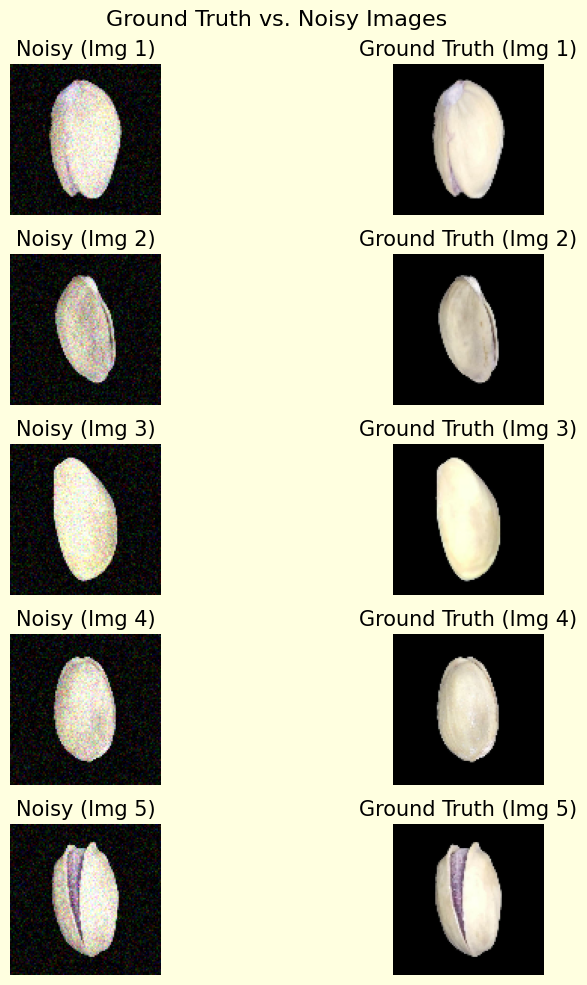

In [9]:
n_examples_to_show = BATCH_SIZE

plt.figure(figsize=(10, 2 * n_examples_to_show))
plt.suptitle("Ground Truth vs. Noisy Images", fontsize=16)

# Take one batch from the dataset
for noisy_batch, gt_batch in train_dataset.take(1):

    actual_batch_size = noisy_batch.shape[0]
    
    num_to_plot = min(n_examples_to_show, actual_batch_size)
    if num_to_plot == 0:
        print("The batch is empty, cannot plot.")
        break

    for i in range(num_to_plot):
        ax = plt.subplot(num_to_plot, 2, 2 * i + 1)
        plt.imshow(noisy_batch[i])
        plt.title(f"Noisy (Img {i+1})")
        plt.axis("off")

        ax = plt.subplot(num_to_plot, 2, 2 * i + 2)
        plt.imshow(gt_batch[i])
        plt.title(f"Ground Truth (Img {i+1})")
        plt.axis("off")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# C. 1st Model = Regular Autoencoder
---

The first model is the one specified in the exam, which is a classic convolutional autoencoder. This model's architecture is elegantly symmetrical, often described as a 'butterfly' or 'hourglass' shape, and is perfectly suited for tasks like feature extraction and, in our case, image denoising.

The model's operation is divided into two distinct parts. The first part is the encoder, which acts like a compressor. It takes the 100x100 input image and, through a series of convolutional and max-pooling layers, progressively shrinks its height and width down to 25x25. While the spatial size decreases, the number of feature channels increases, forcing the network to encode the most critical information into a dense, low-dimensional representation known as the bottleneck.

Following the bottleneck, the decoder takes over. Its job is to act as a reconstructor. Using upsampling or transposed convolution layers, it meticulously rebuilds the image from that compressed representation, expanding it back to the original 100x100 size. Because the model is trained to minimize the difference between the output and the original clean image, it learns that the noise is irrelevant information that shouldn't be encoded. As a result, the decoder learns to generate a clean, denoised version of the input.

## Model Building

In [ ]:
def build_correct_ae(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)):
    inputs = Input(shape=input_shape)

    # Encoder
    e1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)          # Shape: (100, 100, 32)
    p1 = MaxPooling2D((2, 2))(e1)                                               # Shape: (50, 50, 32)
    
    e2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)              # Shape: (50, 50, 64)
    p2 = MaxPooling2D((2, 2))(e2)                                               # Shape: (25, 25, 64)
    
    # Bottleneck
    bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)      # Shape: (25, 25, 64) --> we can see here that the number feature channels increase after every layer and having the max value of 64 at the bottlneck 
                                                                                # meaning that this layer save the most detailed feature of the images
    # Decoder
    d1 = UpSampling2D((2, 2))(bottleneck)                                       # Shape: (50, 50, 64)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(d1)              # Shape: (50, 50, 32)
    
    d2 = UpSampling2D((2, 2))(c1)                                               # Shape: (100, 100, 32)
    
    # Output Layer
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d2)       # Shape: (100, 100, 3)

    autoencoder = Model(inputs, outputs, name='image_matching_autoencoder')
    return autoencoder

autoencoder = build_correct_ae()

The model then compiled with Loss of MSE and Metrics of MAE and then the optimizer of Adam with Learning rate of 1e-3. Some callbacks also used to monitor the training process like keeping the best models and reducing the learning rate when the training is stuck. And if no improvement needed, then it will be stopped by the early_stopping.

In [48]:
autoencoder.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint("best_model_butterfly.h5", save_best_only=True, monitor='val_loss', mode='min')

checkpoint = [early_stopping, reduce_lr, model_checkpoint]

autoencoder.summary()

Model: "image_matching_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_37 (Conv2D)          (None, 25, 

## Training

In [49]:
history = autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=checkpoint,
    verbose=1
)

Epoch 1/50
171/171 [==============================] - 2s 10ms/step - loss: 0.0126 - mae: 0.0446 - val_loss: 0.0029 - val_mae: 0.0204 - lr: 0.0010
Epoch 2/50
171/171 [==============================] - 3s 15ms/step - loss: 0.0024 - mae: 0.0174 - val_loss: 0.0020 - val_mae: 0.0155 - lr: 0.0010
Epoch 3/50
171/171 [==============================] - 2s 14ms/step - loss: 0.0019 - mae: 0.0153 - val_loss: 0.0016 - val_mae: 0.0141 - lr: 0.0010
Epoch 4/50
171/171 [==============================] - 3s 15ms/step - loss: 0.0016 - mae: 0.0139 - val_loss: 0.0015 - val_mae: 0.0138 - lr: 0.0010
Epoch 5/50
171/171 [==============================] - 3s 16ms/step - loss: 0.0014 - mae: 0.0129 - val_loss: 0.0013 - val_mae: 0.0124 - lr: 0.0010
Epoch 6/50
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0125 - val_loss: 0.0012 - val_mae: 0.0117 - lr: 0.0010
Epoch 7/50
171/171 [==============================] - 1s 7ms/step - loss: 0.0011 - mae: 0.0114 - val_loss: 0.0012 - val_mae: 

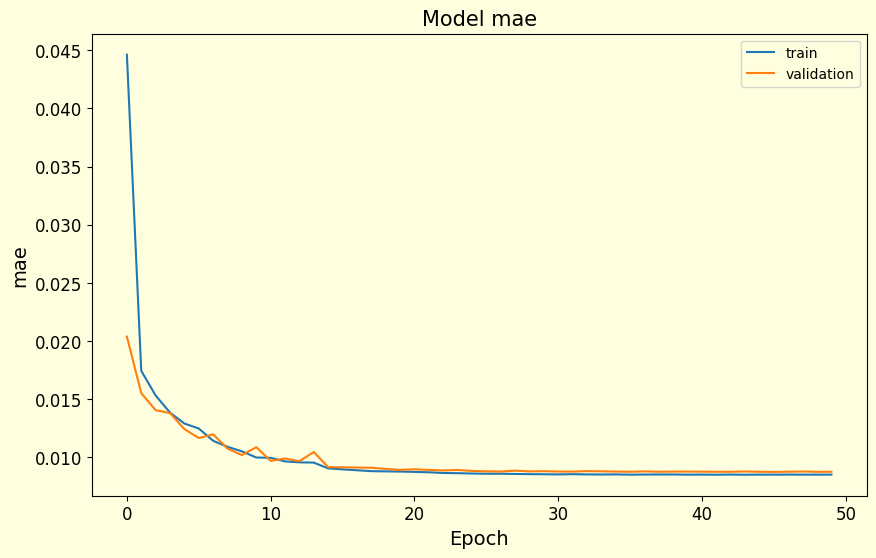

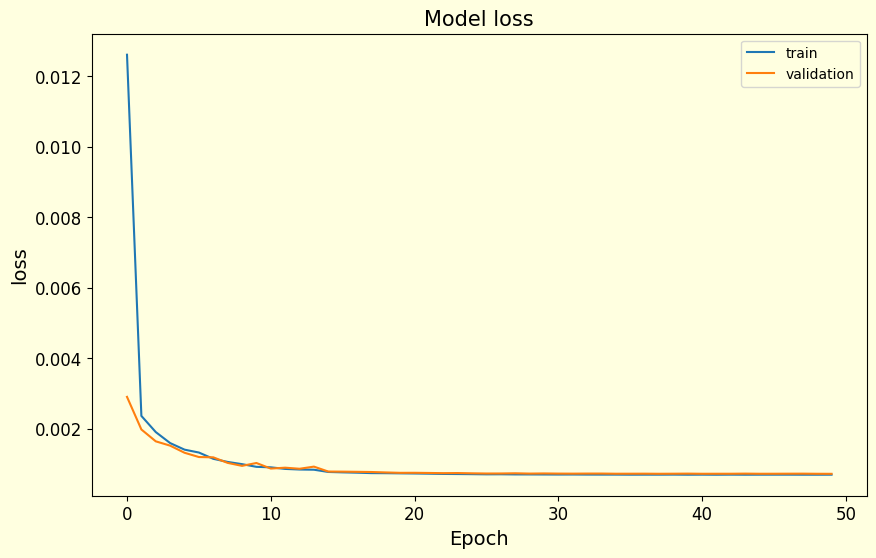

In [50]:
def plot_history(history, metric='accuracy'):
    plt.figure(figsize=(10,6))
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history['val_' + metric], label='validation')
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history, 'mae')
plot_history(history, 'loss')

From these plot we can see that both of the mae and loss from the model is converge and belom 2e-3 this means that the model is low on overfitting risk and learning well with that number of loss.

## Evaluation

### Qualitative Evaluation

2/2 [==============================] - 0s 8ms/step


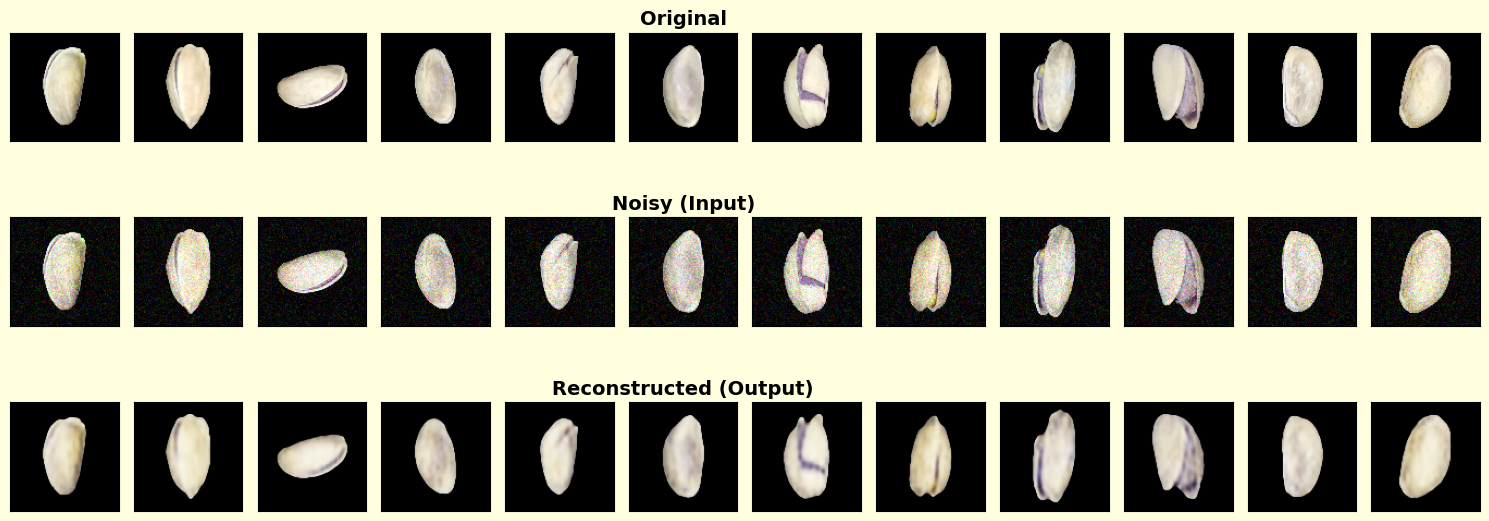

In [51]:
num_images_to_show = 12
noisy_images_list = []
original_images_list = []

for noisy_batch, original_batch in test_dataset.take(num_images_to_show):
    
    noisy_images_list.append(noisy_batch)
    original_images_list.append(original_batch)

noisy_images = np.vstack(noisy_images_list)
original_images = np.vstack(original_images_list)

reconstructed_images = autoencoder.predict(noisy_images)

plt.figure(figsize=(15, 6))
for i in range(num_images_to_show):
    # Display Original Image
    ax = plt.subplot(3, num_images_to_show, i + 1)
    plt.imshow(original_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == round(num_images_to_show/2 - 1, 0):
        ax.set_title("Original")

    # Display Noisy Image
    ax = plt.subplot(3, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(noisy_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == round(num_images_to_show/2 - 1, 0): 
        ax.set_title("Noisy (Input)")

    # Display Reconstructed Image
    ax = plt.subplot(3, num_images_to_show, i + 1 + 2 * num_images_to_show)
    plt.imshow(reconstructed_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == round(num_images_to_show/2 - 1, 0):
        ax.set_title("Reconstructed (Output)")

plt.tight_layout()
plt.show()

We can see here in our before-noised-reconstructed that the model is able to reconstruct the image well. It can remove the grain from the images. Howeveer as a drawback from the ability tho remove the noise from the image. We can see that some of the detail like detailed edge is missing. It shows that even tho our image is able to remove the noise, it still have some inability to provide 100% same picture as the real one

### SSIM

In [52]:
reconstructed_images_full = autoencoder.predict(test_dataset)
original_images_full = np.concatenate([y for x, y in test_dataset], axis=0)
num_actual_images = len(original_images_full)

ssim_scores = []

for i in range(num_actual_images):
    original_img = original_images_full[i]
    recon_img = reconstructed_images_full[i]

    score = ssim(original_img, recon_img, channel_axis=2, data_range=1.0)
    ssim_scores.append(score)

mean_ssim = np.mean(ssim_scores)
print(f"\nMean SSIM over the ENTIRE test set: {mean_ssim:.4f}")

21/21 [==============================] - 0s 4ms/step

Mean SSIM over the ENTIRE test set: 0.9563


A high SSIM value indicates strong similarity between the two images, with a maximum value of 1.0 representing perfect identicalness. In this context, an SSIM score of 0.95 for the reconstructed images demonstrates that our U-Net denoising autoencoder exhibits excellent performance in restoring the noisy input images.

# D. 2nd model - Autoencoder using U-Net
---
[LO1, LO2, LO3, LO4 – 10 poin] Lakukan modifikasi model autoencoder yang diberikan, anda dapat
mengubah susunan arsitektur encoder atau decodernya

After doing the training with a regular model of auto-encoder with the butterfly/hourglass shape and getting a very decent result with a very great SSIM, i think it would be interesting if we do an experiment with U-Net, An architecture that is built with a skip-connection feature that ensure some of the less-detailed feature are being kept because not all features are compacted to the bottleneck, but is sent to decoder directly from encoder. This way we would be able to preserve more features of the data

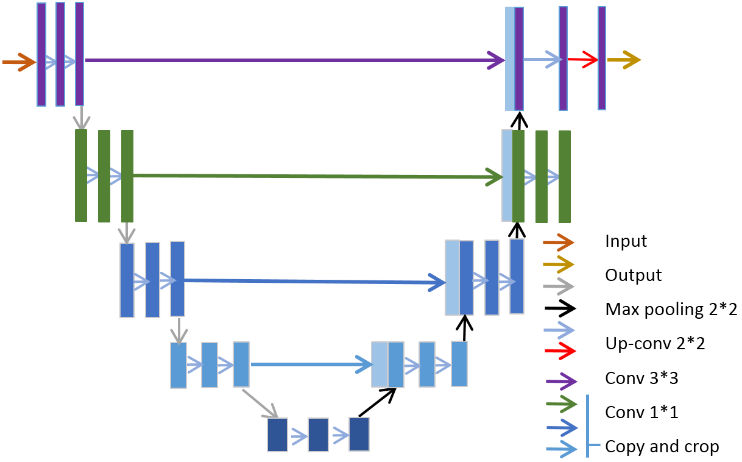

In [26]:
Image.open("unet_arch.jpg")

This is the architecture for the U-Net, we can see that the feature from the encoder are some passed to the decoder so the connection is skipped (shown by arrows)

## Building the model

First we gonna make the function for each encoder and decoder so it will be easier for us to built the unet which, and of course for cleaner code.

ConvBlockunet is used to make all convolution block for the encoder and decoder. So its not mecessary need to be coded again the the encoder and decoder.

Encoder block is build to extract the features using conv_block_unet and then downsample the feature map using maxpooling. It will later return both of before pooling and after pooling features that will be used for downsample and for skip connection. This is the part that make skip connection inn U-Net Possible

While decoder is used to upsamples the input and concatenate the skip features with the upsampled features.

In [27]:
def conv_block_unet(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block_unet(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, crop_size):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    if crop_size:
        skip_features = Cropping2D(cropping=crop_size)(skip_features)
    x = Concatenate()([x, skip_features])
    x = conv_block_unet(x, num_filters)
    return x


In this model some step are done:
1. Inputs --> Using the height, width, and channel of all the images
2. Building Encoder, getting 2 features, s and p, where <br> 
- s is for skip features, and 
- p is for next layer of encoder

3. Bridge --> Being the connector from the encoder to decoder. This layer contains the most features information that was being compacted/pressed into small size of maps
4. Decoder --> Build the decoder to decode the image from bridge using the help of skip features from the encoder part<br>
- Some cropping are done to maintain the size to be the same with the neighboring encoder so skip connection is possible

5. Conv2D Tranpose --> First step is to make the layer of 96x96 for more transpose <br>
Then cropping is done ensure that it will go to 100 later <br>
Them some Conv2D Transpose is done to size of 100, this method is chosen instead of Resizing output layer to maintain it pixel informations better.

6. Model is then being compiled Adam Optimizer with 1e-03 learning rate and MAE as metrics

7. The Loss used here is a custom LOSS, made by combining SSIM and MSE with ratio of : 8MSE + 2SSIM. This si done to prevent the model turns into an image segmentation model.

In [ ]:
def build_unet():
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    # Encoder
    s1, p1 = encoder_block(inputs, 64)  # 100x100 -> 50x50
    s2, p2 = encoder_block(p1, 128)    # 50x50 -> 25x25
    s3, p3 = encoder_block(p2, 256)    # 25x25 -> 12x12

    # Bridge
    b1 = conv_block_unet(p3, 512)      # 12x12

    # Decoder --> many cropping needed to handle image of size 100x100 
    # Some input are also taken from s (skip connection)
    d1 = decoder_block(b1, s3, 256, crop_size=((0, 1), (0, 1)))  # 12x12 -> 24x24, crop s3 (25x25) to 24x24
    d2 = decoder_block(d1, s2, 128, crop_size=((1, 1), (1, 1)))  # 24x24 -> 48x48, crop s2 (50x50) to 48x48
    d3 = decoder_block(d2, s1, 64, crop_size=((2, 2), (2, 2)))   # 48x48 -> 96x96, crop s1 (100x100) to 96x96

    # Adjust to 100x100 using a different Conv2D transpose outside the decoder block func.
    x = Conv2DTranspose(64, (2, 2), strides=1, padding="same")(d3)  # 96x96 -> 96x96
    x = Cropping2D(cropping=((2, 2), (2, 2)))(x)                    # 96x96 -> 92x92
    x = Conv2DTranspose(64, (3, 3), strides=1, padding="valid")(x)  # 92x92 -> 94x94
    x = Conv2DTranspose(64, (3, 3), strides=1, padding="valid")(x)  # 94x94 -> 96x96
    x = Conv2DTranspose(64, (3, 3), strides=1, padding="valid")(x)  # 96x96 -> 98x98
    x = Conv2DTranspose(64, (3, 3), strides=1, padding="valid")(x)  # 98x98 -> 100x100

    # Output
    outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(x)  # 100x100x3

    model = Model(inputs, outputs)
    return model

def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

# Combine MSE and SSIM
def combined_loss(y_true, y_pred, alpha=0.8):
    # alpha 0.8 means 80% MSE, 20% SSIM
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = ssim_loss(y_true, y_pred)
    return alpha * mse + (1 - alpha) * ssim

# Build and compile
unet = build_unet()
unet.compile(loss=combined_loss, optimizer=Adam(learning_rate=0.001), metrics=['mae'])
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 100, 100, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 100, 100, 64  256        ['conv2d_30[0][0]']              
 ormalization)                  )                                                           

Some callbacks are used again to monitor the training process like
- Early Stopping
- Reduce Learning Rate on Plateau
- Model Checkpoint

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint("best_model_unet_final2.h5", save_best_only=True, monitor='val_loss', mode='min')

checkpoint = [early_stopping, reduce_lr, model_checkpoint]

## Training

In [30]:
history_unet = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=checkpoint,
    verbose=1
)

Epoch 1/50
171/171 [==============================] - 12s 51ms/step - loss: 0.0439 - mae: 0.0558 - val_loss: 0.0423 - val_mae: 0.0555 - lr: 0.0010
Epoch 2/50
171/171 [==============================] - 8s 47ms/step - loss: 0.0357 - mae: 0.0502 - val_loss: 0.0393 - val_mae: 0.0519 - lr: 0.0010
Epoch 3/50
171/171 [==============================] - 8s 46ms/step - loss: 0.0365 - mae: 0.0501 - val_loss: 0.0374 - val_mae: 0.0508 - lr: 0.0010
Epoch 4/50
171/171 [==============================] - 8s 48ms/step - loss: 0.0353 - mae: 0.0497 - val_loss: 0.0353 - val_mae: 0.0505 - lr: 0.0010
Epoch 5/50
171/171 [==============================] - 8s 47ms/step - loss: 0.0215 - mae: 0.0313 - val_loss: 0.0277 - val_mae: 0.0454 - lr: 0.0010
Epoch 6/50
171/171 [==============================] - 8s 47ms/step - loss: 0.0077 - mae: 0.0115 - val_loss: 0.0086 - val_mae: 0.0154 - lr: 0.0010
Epoch 7/50
171/171 [==============================] - 8s 48ms/step - loss: 0.0072 - mae: 0.0105 - val_loss: 0.0080 - val_ma

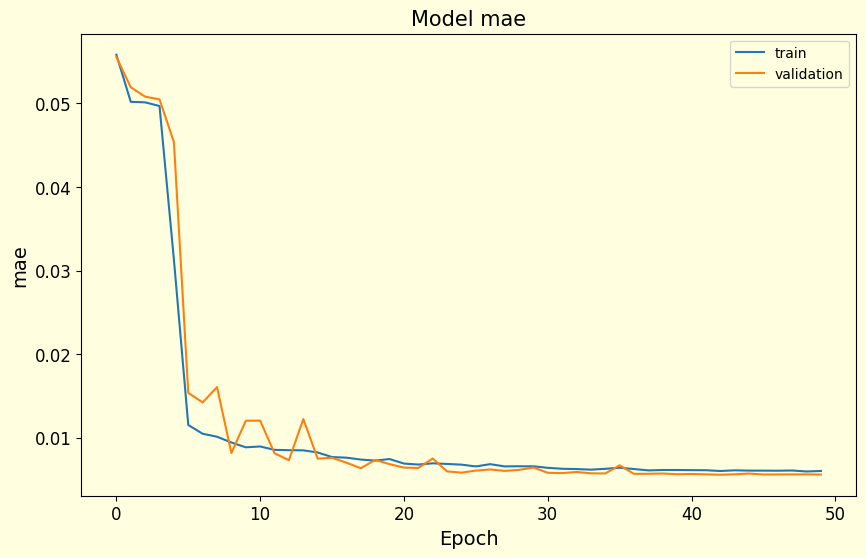

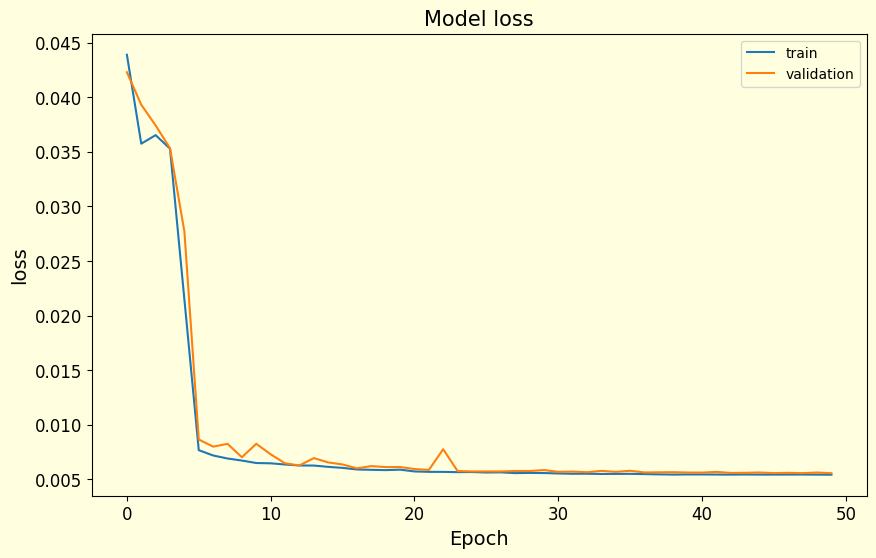

In [31]:
history_unet.history.keys()

def plot_history(history, metric='accuracy'):
    plt.figure(figsize=(10,6))
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history['val_' + metric], label='validation')
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history_unet, 'mae')
plot_history(history_unet, 'loss')

From the lost plot we can see here that the model risk of overfitting is small. The train and validation both loss and mae, shows a convergence result

## Evaluation

### Qualitative Evalution

4/4 [==============================] - 1s 193ms/step


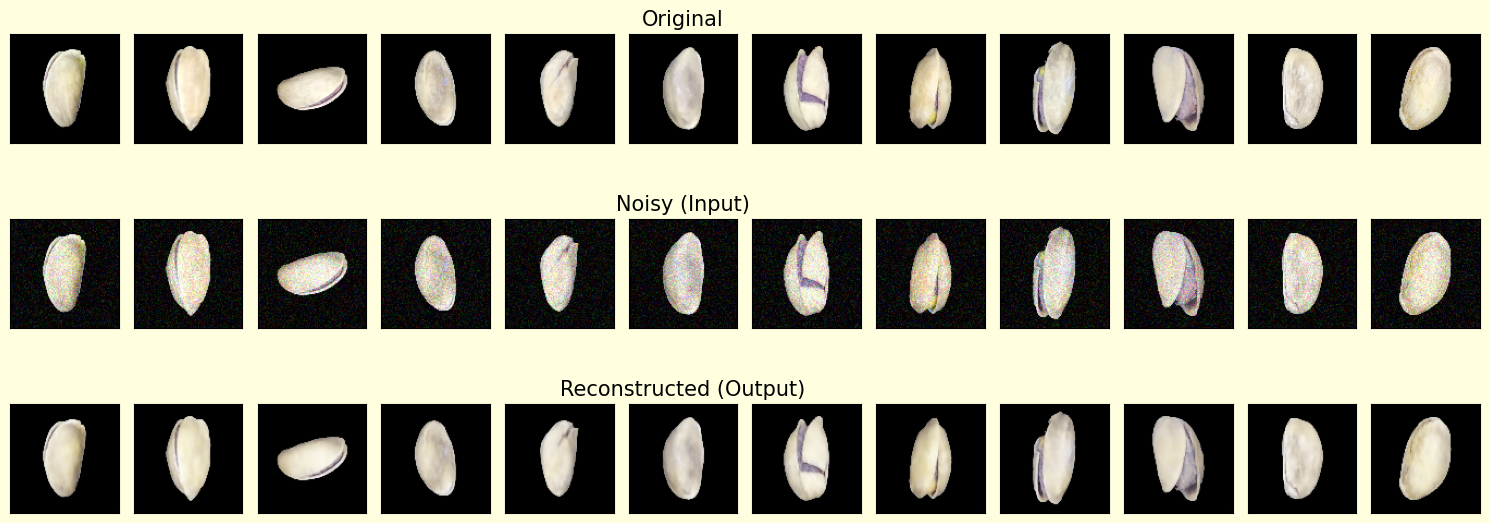

In [34]:
num_predict = len(test_paths)
num_images_to_show = 12
noisy_images_list = []
original_images_list = []

for noisy_batch, original_batch in test_dataset.take(num_predict):
    noisy_images_list.append(noisy_batch)
    original_images_list.append(original_batch)

noisy_images = np.vstack(noisy_images_list)
original_images = np.vstack(original_images_list)

reconstructed_images = unet.predict(noisy_images)

plt.figure(figsize=(15, 6))
for i in range(num_images_to_show):
    # Display Original Image
    ax = plt.subplot(3, num_images_to_show, i + 1)
    plt.imshow(original_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == round(num_images_to_show/2 - 1, 0):
        ax.set_title("Original")

    # Display Noisy Image
    ax = plt.subplot(3, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(noisy_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == round(num_images_to_show/2 - 1, 0): 
        ax.set_title("Noisy (Input)")

    # Display Reconstructed Image
    ax = plt.subplot(3, num_images_to_show, i + 1 + 2 * num_images_to_show)
    plt.imshow(reconstructed_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == round(num_images_to_show/2 - 1, 0):
        ax.set_title("Reconstructed (Output)")

plt.tight_layout()
plt.show()

In this image example we can see that the image shown noised with a good performance from the model. We can see that the gaussian noise is dissapeared. However some of tehe details are getting blurred from the image, while this model able to remove the noise, the model also remove some of the small details in the images.

### SSIM

In [35]:
reconstructed_images_full = unet.predict(test_dataset)
original_images_full = np.concatenate([y for x, y in test_dataset], axis=0)
num_actual_images = len(original_images_full)

ssim_scores = []

for i in range(num_actual_images):
    original_img = original_images_full[i]
    recon_img = reconstructed_images_full[i]

    score = ssim(original_img, recon_img, channel_axis=2, data_range=1.0)
    ssim_scores.append(score)

mean_ssim = np.mean(ssim_scores)
print(f"\nMean SSIM using UNET over the ENTIRE test set: {mean_ssim:.4f}")

21/21 [==============================] - 1s 27ms/step

Mean SSIM using UNET over the ENTIRE test set: 0.9766


Same as the model before, the model here is also having a high SSIM value of 0.97 meaning that this model is even better from the previous model. This score suggests that the model has successfully learned to preserve not only the overall pixel values but also the essential structural components, textures, and contrast characteristics of the original (clean) pistachio images. The high SSIM signifies that the reconstructed output images are perceptually very similar to the ground truth (real image dataset)

# E. Conclusion
---

Comnparing 2 models based on their SSIM, We can see that the second model, U-Net giving a better result (0.9766 vs 0.9563)

Both of the model, even for the base model is giving a very great result of SSIM.

Analysis :
- The data is not diverse enough, its just a bunch of pistachio pictures for 2 varieties which make it very easy for our model to remember it
- The noise given is too little (we still can see the original images clearly with eyes)

Well the 2nd model, (Unet) is giving a better result. Thanks for the Skip Connection features in the architecture. It gives the model the ability to gain a wider detail with this feature. While in the original autoencoder just compacting all the details in a smaller and compact bridge, the skip connection gives more info about the past layers data.

Tho the second model is better, but for inference, i think i'd rather choose to use the 1st model for its lightweight-70 thousands parameters with just a little difference of SSIM.Instead of using UNet with 7m params